# Homework 2 (Due Thursday Dec 1, 6:29pm PST)

Please submit as a notebook in the format `HW2_FIRSTNAME_LASTNAME_USCID.ipynb` in a group chat to me and the TAs.

Your `USCID` is your student 10-digit ID.

### Part I.  Topic Modelling and Analysis (5pts)

Pick from **one** of the dataset options below:
* **Negative McDonalds Yelp reviews**: `datasets/mcdonalds-yelp-negative-reviews.csv`
* **[Top 5000 Udemy courses](https://www.kaggle.com/datasets/90eededa5561eee7f62c0e68ecdad14c2bdb58bc923834067025dee655a6083e?resource=download)** - a Kaggle dataset of the course descriptions of the top 5000 Udemy courses in 2022: `datasets/top5000_udemy.csv`

In your notebook, explore the data and perform topic modelling. You may use any vectorization or text preprocessing techniques we have discussed.

In order to earn full credit, you must:

* Show the **# of topics you tried, and explain why you ultimately decided on the final #**.
* Demonstrate **adequate text preprocessing (there are likely obvious stopwords / fuzzy matching / regex groupings that can be done to improve the final results)** - show what you tried.
* In 2-3 sentences: A **business analysis of these topics - what do they reveal as actionable next steps or insights for McDonalds or Udemy?** Please be specific in your recommendations/insights.
    - **Not specific**: *We recommend Amazon look into the quality of their toys, since the reviews show disatisfaction with the value of their product.*
    - **Specific**: *Amazon should explore more durable batteries/hardwares. For example, X% of reviews mention that the toys' batteries were broken or immediately died. This is part of a larger theme of components not being ready to use out the box, which often leads to disappointment on holiday occasions when children open up their gifts. See the following document snippets as examples:...*

#### 1. Loading Data 

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
reviews = pd.read_csv("../datasets/mcdonalds-yelp-negative-reviews.csv", encoding='latin-1')
text = reviews["review"].values

### 2. Data Cleaning and Text Preprocessing

In [2]:
reviews['reviews_processed'] = reviews['review']

# Remove punctuation
from textacy.preprocessing.remove import punctuation
reviews['reviews_processed'] = reviews['reviews_processed'].apply(punctuation)

# Convert to lowercase 
reviews['reviews_processed'] = reviews['reviews_processed'].map(lambda x: x.lower())

# Replace common entities/concepts 
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
reviews['reviews_processed'] = reviews['reviews_processed'].\
 apply(urls).\
 apply(hashtags).\
 apply(currency_symbols).\
 apply(emojis).\
 apply(emails)
# apply(numbers)
# we won't remove numbers because it gives us valuable information 

# Remove or normalize undesired text elements 
#from collections import Counter
#from textacy.preprocessing.normalize import quotation_marks, bullet_points
#quotes = ['"','“','”']

# Clean out the different ways of saying mcdonalds to a standard form 
reviews['reviews_processed'] = reviews['reviews_processed'].str.replace(r"\b(?:mc ?donald(?:s)?|mcds?)\b",'MCDONALDS_TOKEN')
# Clean out the different ways of saying drive through to a standard form 
reviews['reviews_processed'] = reviews['reviews_processed'].str.replace(r"(?:D|d)rive(?:-)*\s*(?:T|t)(?:hru|hrough)", "DRIVE_THROUGH_TOKEN")
reviews.head(10)


/var/folders/zz/gt_tn3454131nr1dxcqk06b40000gn/T/ipykernel_81487/3339237787.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['reviews_processed'] = reviews['reviews_processed'].str.replace(r"\b(?:mc ?donald(?:s)?|mcds?)\b",'MCDONALDS_TOKEN')
/var/folders/zz/gt_tn3454131nr1dxcqk06b40000gn/T/ipykernel_81487/3339237787.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['reviews_processed'] = reviews['reviews_processed'].str.replace(r"(?:D|d)rive(?:-)*\s*(?:T|t)(?:hru|hrough)", "DRIVE_THROUGH_TOKEN")


,_unit_id,city,review,reviews_processed
0,679455653,Atlanta,"I'm not a huge mcds lover, but I've been to be...",i m not a huge MCDONALDS_TOKEN lover but i ve...
1,679455654,Atlanta,Terrible customer service. I came in at 9:30pm...,terrible customer service i came in at 9 30pm...
2,679455655,Atlanta,"First they ""lost"" my order, actually they gave...",first they lost my order actually they gave...
3,679455656,Atlanta,I see I'm not the only one giving 1 star. Only...,i see i m not the only one giving 1 star only...
4,679455657,Atlanta,"Well, it's McDonald's, so you know what the fo...",well it s MCDONALDS_TOKEN s so you know what...
5,679455658,Atlanta,This has to be one of the worst and slowest Mc...,this has to be one of the worst and slowest MC...
6,679455659,Atlanta,I'm not crazy about this McDonald's. This is p...,i m not crazy about this MCDONALDS_TOKEN s th...
7,679455660,Atlanta,One Star and I'm beng kind. I blame management...,one star and i m beng kind i blame management...
8,679455661,Atlanta,Never been upset about any fast food drive thr...,never been upset about any fast food DRIVE_THR...
9,679455662,Atlanta,This McDonald's has gotten much better. Usuall...,this MCDONALDS_TOKEN s has gotten much better ...


In [3]:
# Lemmatization 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None


# Shoutout to this git repo for providing this code 
# https://gist.github.com/gaurav5430/9fce93759eb2f6b1697883c3782f30de
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

reviews['reviews_processed'] = reviews['reviews_processed'].apply(lemmatize_sentence)

In [4]:
pd.set_option('display.max_colwidth', None)

#### Exploratory Data Analysis

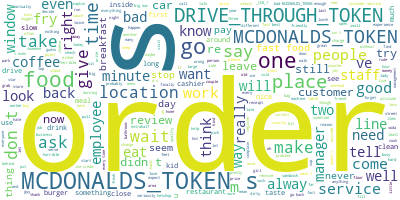

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(reviews['reviews_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
# We are using the word cloud to figure out which extra stopwords to add to our stopword bank 
wordcloud.to_image()

In [6]:


# Add words to the stopwords 
# worst, worst ever, awful, terrible, bad, terrible, look like, mcdonalds, fast food, location, don't, want, review  

In [7]:
# Removing stopwords using gensim 
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS

all_stopwords_gensim = STOPWORDS.union(set(['MCDONALDS_TOKEN', 'look like', 'location', 's']))

reviews['reviews_processed'] = reviews['reviews_processed'].apply(remove_stopwords)
reviews[['review',"reviews_processed"]].head(10)

# Add custom stopwords to improve our result 
# Credit to this stackoverflow page: 
# https://stackoverflow.com/questions/26826002/adding-words-to-stop-words-list-in-tfidfvectorizer-in-sklearn
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
stop.extend('fast food look like mcdonalds_token MCDONALDS_TOKEN'.split())


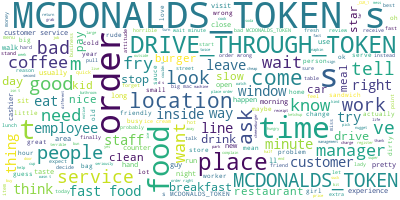

In [8]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(reviews['reviews_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
# We are using the word cloud to figure out which extra stopwords to add to our stopword bank 
wordcloud.to_image()

Using the word cloud, we were able to identify additional stopwords to include. 

In [9]:
# Vectorize the corpus 
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(3,3), min_df=3,
                            max_df=0.4, stop_words=set(stop))

X, terms = vectorizer.fit_transform(reviews['reviews_processed']), vectorizer.get_feature_names_out()
tf_idf = pd.DataFrame(X.toarray(), columns=terms)

print(f"TF-IDF: {tf_idf.shape}")
tf_idf.head(5)

TF-IDF: (1525, 165)


,10 minute fry,10 minute later,10 minute line,10 minute order,10 piece chicken,10 piece nugget,15 minute drive_through_token,15 minute later,15 minute order,15 minute wait,...,wait long line,wait wait wait,want chicken nugget,want ice cream,window ask order,window hand drink,wish negative star,work customer service,work drive_through_token order,worst customer service
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Fit the NMF Model
nmf = NMF(n_components=3)
W = nmf.fit_transform(X)
H = nmf.components_
print(f"Original shape of X is {X.shape}")
print(f"Decomposed W matrix is {W.shape}")
print(f"Decomposed H matrix is {H.shape}")

Original shape of X is (1525, 165)
Decomposed W matrix is (1525, 3)
Decomposed H matrix is (3, 165)


/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


We have decided to use 3 topics for out topic modeling since having any more than 3 topics was leading to duplicate topics showing up and having any less than 3 topics was leading to not capturing meaningful topic groups. 

### Topic Modeling by City
In order to make more targeted and accurate business recommendation, we decided to run our topic modeling for each of the cities that were included in our dataset. We wanted to capture if the topics were different for each city. Therefore, we built a for loop that iterates through all the cities in the dataset and returns 3 topics and top 3 tokens for each topic. 

In [11]:
from typing import List
import numpy as np
# Report Results for TFIDF Vectorizer 
def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 5):
  """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
  for topic, vector in enumerate(H):
    print(f"TOPIC {topic}\n")
    total = vector.sum()
    top_scores = vector.argsort()[::-1][:num_top_tokens]
    token_names = list(map(lambda idx: feature_names[idx], top_scores))
    strengths = list(map(lambda idx: vector[idx] / total, top_scores))
    
    for strength, token_name in zip(strengths, token_names):
      print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
    print(f"=" * 50)

get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 3)

TOPIC 0

open 24 hour (42.4%)

drive_through_token open 24 (9.6%)

come late night (5.4%)

TOPIC 1

wait 10 minute (45.8%)

wait 15 minute (7.1%)

10 minute order (6.4%)

TOPIC 2

bad customer service (58.0%)

order wrong time (14.5%)

terrible customer service (7.2%)



In [12]:
from sklearn.decomposition import LatentDirichletAllocation

# Report Results for LDA
lda = LatentDirichletAllocation(n_components=3)
W = lda.fit_transform(X)
H = lda.components_
get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 3)

TOPIC 0

open 24 hour (3.9%)

order wrong time (3.8%)

sweet sour sauce (3.0%)

TOPIC 1

bad customer service (4.9%)

free wi fi (2.9%)

wait 30 minute (2.4%)

TOPIC 2

wait 10 minute (5.4%)

wait 15 minute (4.1%)

24 hour drive_through_token (3.2%)



In [13]:
# We want to look at top topics for each city to give more targeted recommendations 
# Replace rows with missing cities with "Missing City"
reviews['city'].fillna('Missing City', inplace = True)

# Save a list of cities in our dataset for for loop later 
city_list = list(reviews['city'].unique())
city_list

['Atlanta',
 'Las Vegas',
 'Dallas',
 'Portland',
 'Chicago',
 'Cleveland',
 'Houston',
 'Los Angeles',
 'New York',
 'Missing City']

In [14]:
import warnings
warnings.filterwarnings("ignore")

vectorizer = TfidfVectorizer(ngram_range=(2,3), min_df=3,
                            max_df=0.4, stop_words=set(stop))

# Breakdown by city using NMF

for city in city_list:
    print(city)
    reviews_city = reviews[reviews['city']==city]
    X, terms = vectorizer.fit_transform(reviews_city['reviews_processed']), vectorizer.get_feature_names_out()
    tf_idf = pd.DataFrame(X.toarray(), columns=terms)
    nmf = NMF(n_components=3)
    W = nmf.fit_transform(X)
    H = nmf.components_
    get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 3)

    

Atlanta
TOPIC 0

customer service (25.7%)

order drive_through_token (12.0%)

place order (11.6%)

TOPIC 1

order wrong (17.8%)

northside hospital (17.6%)

10 minute (8.3%)

TOPIC 2

ice cream (55.3%)

particular location (19.8%)

staff super (19.8%)

Las Vegas
TOPIC 0

order right (16.9%)

hash brown (3.7%)

right order (3.0%)

TOPIC 1

big mac (16.9%)

order big (4.1%)

order big mac (3.9%)

TOPIC 2

customer service (15.0%)

late night (3.1%)

service quick (2.3%)

Dallas
TOPIC 0

customer service (67.8%)

play area (9.7%)

big mac (9.6%)

TOPIC 1

parking lot (82.2%)

tell want (11.1%)

drive_through_token order (3.1%)

TOPIC 2

15 minute (100.0%)

order wrong (0.0%)

order right (0.0%)

Portland
TOPIC 0

24 hour (85.8%)

big mac (13.6%)

chicken nugget (0.5%)

TOPIC 1

time order (31.2%)

chicken sandwich (10.9%)

big mac (10.5%)

TOPIC 2

customer service (53.3%)

mess order (22.7%)

time visit (16.0%)

Chicago
TOPIC 0

parking lot (48.9%)



In [15]:
# Breakdown by city using LDA 
vectorizer = TfidfVectorizer(ngram_range=(2,3), min_df=3,
                            max_df=0.4, stop_words=set(stop))

for city in city_list:
    print(city)
    reviews_city = reviews[reviews['city']==city]
    X, terms = vectorizer.fit_transform(reviews_city['reviews_processed']), vectorizer.get_feature_names_out()
    tf_idf = pd.DataFrame(X.toarray(), columns=terms)
    lda = LatentDirichletAllocation(n_components=3)
    W = lda.fit_transform(X)
    H = lda.components_
    get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 3)

Atlanta
TOPIC 0

order drive_through_token (8.8%)

ice cream (8.0%)

late night (7.7%)

TOPIC 1

customer service (10.3%)

place order (5.8%)

poor service (5.7%)

TOPIC 2

northside hospital (10.9%)

10 minute (10.0%)

wait order (8.2%)

Las Vegas
TOPIC 0

customer service (3.1%)

order wrong (2.0%)

ice cream (1.8%)

TOPIC 1

big mac (2.9%)

order right (2.1%)

sweet tea (1.7%)

TOPIC 2

mess order (1.9%)

chicken nugget (1.8%)

hash brown (1.6%)

Dallas
TOPIC 0

15 minute (28.7%)

big mac (24.3%)

tell want (15.3%)

TOPIC 1

parking lot (28.1%)

order wrong (21.1%)

play area (19.8%)

TOPIC 2

customer service (25.5%)

walk door (14.2%)

order right (12.1%)

Portland
TOPIC 0

chicken sandwich (12.1%)

place order (8.7%)

drive_through_token window (8.7%)

TOPIC 1

time order (24.0%)

customer service (21.3%)

big mac (17.1%)

TOPIC 2

24 hour (18.8%)

parking lot (12.5%)

window order (12.3%)

Chicago
TOPIC 0

customer service (5.5%)

order wron

In [16]:
import numpy as np
def get_top_documents_for_each_topic(W: np.array, documents: List[str], num_docs: int = 5):
    sorted_docs = W.argsort(axis=0)[::-1]
    top_docs = sorted_docs[:num_docs].T
    per_document_totals = W.sum(axis=1)
    for topic, top_documents_for_topic in enumerate(top_docs):
        print(f"Topic {topic}")
        for doc in top_documents_for_topic:
            score = W[doc][topic]
            percent_about_topic = round(score / per_document_totals[doc] * 100, 1)
            print(f"{percent_about_topic}%", documents[doc])
            print("=" * 50)

In [17]:
get_top_documents_for_each_topic(W, reviews['review'].tolist())

Topic 0
72.2% This has got to be one of the busiest McDonald's in the metro area ... if not the southeast ... and they are fairly efficient despite being so busy all the time.You can come by just about any time of the day and find the line of cars for the "drive-thru" wrapped around the building...It's generally more efficient to go into the building and place your order than wait in the line of cars spewing smog... and since the building is open 24 hours now that should make it easy to get your McFix...good job, Clairmont McDonald's!
72.2% Typical McDonald's restaurant located at Powers Ferry and New Northside on the north end of the perimeter. I have always avoided this location due to the fact that I'm not really a fan of McDonald's in general, but the other morning on my way to work I was craving some breakfast and only had time to pull into a drive-thru and grab a quick bite to go. Since McDonald's is the only place with a drive-thru on my way to work I stopped by here to grab the

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=3)
W = lda.fit_transform(X)
H = lda.components_
get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 3)

TOPIC 0

customer service (32.5%)

order wrong (14.7%)

open 24 (11.7%)

TOPIC 1

place order (27.1%)

late night (14.4%)

ice cream (14.3%)

TOPIC 2

good service (19.5%)

speak english (11.9%)

24 hour (11.3%)



In [19]:
get_top_documents_for_each_topic(W, reviews['review'].tolist())

Topic 0
75.5% I purchased a specialty coffee in the drive through, but soon after I pulled out and away I realized I had been given a black coffee for the price of $3. Mistakes happen so I kept my receipt and went back exactly a week later within the hour, since I was making the same trip. I went inside, out of respect to show my face that I wasn't trying to scam them, and the manager was working the register. I told him what happened and that I'd like the specialty coffee I originally ordered. He pointed that it had been a week since the original purchase and that he needed proof I wasn't lying about my incorrect order. Mind you, at 6:30am 6 people were all waiting around for their order, which shows slow and poor service. I didn't argue and I walked away leaving my receipt on the counter. I was simply asking for a coffee, not even an entire meal. I don't post about these sort of things, but this time was different. The manager could have easily offered a variety of resolutions, but a

In [20]:
for city in city_list:
    print(city)
    reviews_city = reviews[reviews['city']==city]
    X, terms = vectorizer.fit_transform(reviews_city['reviews_processed']), vectorizer.get_feature_names_out()
    tf_idf = pd.DataFrame(X.toarray(), columns=terms)
    nmf = NMF(n_components=3)
    W = nmf.fit_transform(X)
    H = nmf.components_
    get_top_documents_for_each_topic(W, reviews['review'].tolist())

Atlanta
Topic 0
98.8% Customer service is well below par here. I placed my order through the intercom and was told that I'd have to pay in separate transactions if I were to use more than 1 coupon. I expected that and was fine with it up until I got to the window in which one of the girls working the cashier had a problem with me using the coupons and I quote, mentioned, "I don't give a d*** and a f*** what she wants." I never make it a goal to be difficult to other people and I find it very rude, let alone unnecessary, that I received this treatment. It is part of your job's duties to simply put in a customer's order. If you don't like your job, you have no business being there, and there are plenty of job seekers out there who would be more deserving of your position. To top it off, after I left the restaurant, I opened my bag to find out that I didn't receive everything I ordered and paid for.
100.0% Food is what you would expect from McDonald's but the management and staff could us

When trying to find the topics on our entire dataset, we found that the topics were very general. We thought that it would be more useful and insightful to offer business recommendations by breaking the reviews down by city. If we know what specific problems the McDonald’s in each city is facing, then we can provide specific feedback. 

**CUSTOMER SERVICE**

For Dallas,  Portland, Cleveland, Los Angeles, and New York, we see that customer Service is a large issue (>49%) of a topic. We recommend implementing employee training programs in order to improve customer service quality. 

**DRIVE THROUGH**

For Chicago, Houston, Portland, and Los Angeles we see that another main issue is the drive-through. Looking at the top reviews for each city, this is mainly due to the drive-through taking a long time. For actionable insights, we recommend looking at rush hours for individual stores. If each store knows when their rush hour is, then we can staff more employees during those hours to ensure a smoother experience. Another recommendation that we have is to include promotions for in-store pickup to implement a quicker throughput process. 

### Part II. Emotion Classification (5 pts)

Use the `datasets/emotions_dataset.zip` (see the original Dataset source on [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)) to build a classification model that predicts the emotion of sentence. If you would like, you may classify only the top 4 emotions, and group all other classes as `Other`. 

In order to earn full credit, you must:

* Show the performance of your model with `CountVectorizer`, `TfIdfVectorizer`, `word2vec`, and `glove` embeddings.
    - for `word2vec`, make sure not to use the `en_core_web_sm` dataset (these are not real embeddings)
* Perform text preprocessing (or explain why it was not necessary):
    - stopword removal
    - ngram tokenization
    - stemming/lemmatization
    - fuzzy matching / regex cleaning / etc. (as you deem necessary, but show that you analyzed the text to make your decision)
* Show **AUROC / F1 scores** for on the holdout (test + validation) datasets.
* A brief discussion (2-3 sentences) of what could improve your model and why.

### 1. Importing Datasets 

In [21]:
train_df = pd.read_csv('../datasets/emotions/train.txt',header=None, names=['text'])
train_df[['text','emotion']] = train_df['text'].str.split(';',expand=True)
train_df['type'] = "train"
test_df = pd.read_csv('../datasets/emotions/test.txt',header=None, names=['text'])
test_df[['text','emotion']] = test_df['text'].str.split(';',expand=True)
test_df['type'] = "test"
val_df = pd.read_csv('../datasets/emotions/val.txt',header=None, names=['text'])
val_df[['text','emotion']] = val_df['text'].str.split(';',expand=True)
val_df['type'] = "val"

df = train_df.append(test_df.append(val_df , ignore_index=True) , ignore_index=True)

df.head()

,text,emotion,type
0,i didnt feel humiliated,sadness,train
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness,train
2,im grabbing a minute to post i feel greedy wrong,anger,train
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love,train
4,i am feeling grouchy,anger,train


In [22]:
# Checking if all the data have been appended correctly
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)
print(df.shape)

print(df['type'].unique())

(16000, 3)
(2000, 3)
(2000, 3)
(20000, 3)
['train' 'test' 'val']


### 2. Text Preprocessing


- **Stopword removal:** We want remove stopwords so that we can only focus on words that are relavent for predicting the sentiment. We don't want common recurring words to override the actual sentiment in the text. However, we do want to remove certain words from the list of stopwords from the packages we are using because in our text, words that change the meaning to the opposute like didn't, haven't, or wasn't. 
- **N-gram tokenization:** We wanted to do n-gram tokenization because there are word pairings that change the sentiment. For example "didn't feel humiliated" mean something different compared to just "humiliated". So we want to account for bigrams and trigrams. However, since we have a pretty extensive dataset, we kept running out of memory to run our models with n-grams. Therefore, we opted to not to n-gram for this homework. 
- **Stemming/lemmetization:** we don't want to do stemming or lemmetization because there are certain words that may have lose its original sentiment if we lemmetize them. For example, hope and hopeless would both be lemmetized to hope, but this completely alters the sentiment of the "hopeless". 
- **Fuzzy-matching/Regex:** Upon drawing multiple randome samples of the text and physically examining the text in the dataset, we determined that there aren't too many spelling errors or issues with text quality. Therefore, we won't be performing fuzzy-matching or Regex. 


In [23]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
# Add to stopword: feel, feeling
stop = stopwords.words('english')
stop.extend(['feel','feeling'])

# Remove from stopword
stop.remove('didn')
stop.remove('didn\'t')

# https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
df['text_clean'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head(10)

,text,emotion,type,text_clean
0,i didnt feel humiliated,sadness,train,didnt humiliated
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness,train,go hopeless damned hopeful around someone cares awake
2,im grabbing a minute to post i feel greedy wrong,anger,train,im grabbing minute post greedy wrong
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love,train,ever nostalgic fireplace know still property
4,i am feeling grouchy,anger,train,grouchy
5,ive been feeling a little burdened lately wasnt sure why that was,sadness,train,ive little burdened lately wasnt sure
6,ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny,surprise,train,ive taking milligrams times recommended amount ive fallen asleep lot faster also like funny
7,i feel as confused about life as a teenager or as jaded as a year old man,fear,train,confused life teenager jaded year old man
8,i have been with petronas for years i feel that petronas has performed well and made a huge profit,joy,train,petronas years petronas performed well made huge profit
9,i feel romantic too,love,train,romantic


#### Word2Vec Build Classification Model ####

In [25]:
import spacy
# load the language model, but we disable the ner (named entity recognition) and parser (dependency parser)
# since we don't need them for our use case to speed things up
nlp = spacy.load('en_core_web_md', disable = ['ner', 'parser'])

import numpy as np
def process_text(text):
  """
  This function will use Spacy to perform stopword removal and lemmatization.
  """
  doc = nlp(text)
  processed_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
  # this will get the word2vec embeddings for the processed text (the average of each token in the doc's word2vec embeddings)
  return np.array(nlp(processed_text).vector)

In [26]:
# use pandas' apply(...) method to apply this process_text function to each row's text field
df["vectors"] = df.text.apply(process_text)
X = np.array([vector for vector in df["vectors"]])
y = df["emotion"]
X.shape

(20000, 300)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

print(f"Training dataset is {X_train.shape}")
print(f"Training target is {y_train.shape}")
print(f"Test dataset is {X_test.shape}")
print(f"Test target is {y_test.shape}")

from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)
training_predictions = logistic_regression.predict(X_train)
training_predictions[:5] # these are our model's prediction for first 5 documents in the training dataset

from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train, training_predictions)

# we get 65.3% accuracy on the training data using word2vec 
print(logistic_regression.score(X_train, y_train))

# we got 62.7% accuracy on the test data
print(logistic_regression.score(X_test, y_test))

Training dataset is (15000, 300)
Training target is (15000,)
Test dataset is (5000, 300)
Test target is (5000,)
0.6534
0.6272


In [28]:
from sklearn.metrics import roc_auc_score
y_probabilities = logistic_regression.predict_proba(X_test)
roc_auc_score(y_test, y_probabilities, multi_class="ovo")

0.8674393049275498

#### Count Vectorizer Classification Model

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df["text_clean"])
y = df["emotion"].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# calculate accuracy
print(f"Training accuracy: {np.mean(y_pred == y_test)}")

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

Training accuracy: 0.89175


array([[ 498,   27,   24,    2,   39,    2],
       [  18,  401,   15,    1,   35,   13],
       [   4,    7, 1237,   43,   20,    9],
       [   3,    1,   59,  238,    4,    2],
       [  19,   10,   26,   10, 1072,    1],
       [   2,   24,    8,    0,    5,  121]])

In [31]:
from sklearn.metrics import roc_auc_score
y_probabilities = lr.predict_proba(X_test)

roc_auc_score(y_pred, y_probabilities, multi_class="ovo")

0.9997953365828707

#### TFIDF Vectorizer Model

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df["text_clean"])
y = df["emotion"].values

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# calculate accuracy
print(f"Training accuracy: {np.mean(y_pred == y_test)}")

confusion_matrix(y_test, y_pred)

Training accuracy: 0.87175


array([[ 428,    5,   44,    3,   41,    0],
       [  20,  395,   55,    2,   40,    7],
       [   3,    1, 1284,   27,   26,    2],
       [   6,    0,   96,  215,   10,    0],
       [  21,    4,   34,    2, 1089,    1],
       [   2,   19,   32,    0,   10,   76]])

In [33]:
from sklearn.metrics import roc_auc_score
y_probabilities = lr.predict_proba(X_test)

roc_auc_score(y_pred, y_probabilities, multi_class="ovo")

0.9976290473092261

**EMOTION CLASSIFICATION** 

We can improve our model by increasing the quality of the data that we input into our machine learning model. One way we can improve our input data is by further filtering out words that do not have positive and negative sentiments from our dataset. This can be words that may be part of the story, but do not convey any particular sentiment, such as “everyday” or “kitchen”. 

Additionally, we found that performing n-gram tokenization on our dataset was too computationally heavy on our systems. It may be better to use bigrams or tri-grams for this machine learning model as it may more accurately capture the sentiments of some emotions. For example, a bi-gram model may capture accurately predict the sentiment of “Not_happy”. 